<center><font color="green", size="6">PUBG Game Prediction</font></center>

<center><img src="https://media.giphy.com/media/ZuToOLrJKl9eP3F3eS/giphy.gif"></img></center>

## Table of Content

1. [Import all libraries](#libraries)
2. [Reading Dataset](#reading_data)
3. [Wrangling Data](#wrangling)
4. [EDA](#eda)
5. [Feature Engineering](#feature_engineering)
6. [ML- Catboosts model](#model)
7. [Prediction](#prediction)

## <font color="green">Import all Libraries</font> <a class='anchor' id='libraries'></a>

In [1]:
# !pip install catboost

In [2]:
# standard libraries
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] == (16,6)

import seaborn as sns

# handling warnings
import warnings
warnings.filterwarnings("ignore")

# for model training
from sklearn.preprocessing import StandardScaler # scaling the data
from sklearn.model_selection import train_test_split # split the test and train data

# ml model
import catboost as cb

# model evaluation
from sklearn.metrics import mean_squared_error, r2_score

## <font color="green">Reading Dataset</font> <a class='anchor' id='reading_data'></a>

In [3]:
dataset = pd.read_csv("PUBG_Game_Prediction_data.csv")

In [4]:
dataset.shape

(4446966, 29)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
# coppied the data
data=dataset

## <font color="green">Data Wrangling</font> <a class='anchor' id='wrangling'></a>

In [7]:
# check for the null values
data.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

There is only one null value in winPlacePerc,
and it is also not important one from these huge data, so delete this one.

In [8]:
data.dropna(inplace=True)

Create new parameter to know, how many players are in game.

In [9]:
data['totalPlayers'] = data.groupby('matchId')['matchId'].transform('count')

In [10]:
# new data
data.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,totalPlayers
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


Distribution of totalPlayers joined in game (above 75).

<AxesSubplot: xlabel='totalPlayers', ylabel='count'>

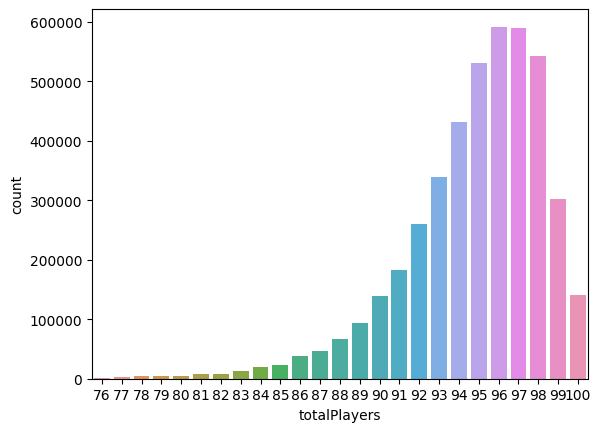

In [11]:
sns.countplot(data[data['totalPlayers']>75], x='totalPlayers')

### Analysis of Data

First remove outliers, as we are build our model as generalize.
So, we remove the hacker (cheater in game), which are extraordanary in game, 
and also who are very pro player, to generalize our model, which is suitable for all players.

Kills without moving

<img src="https://media.giphy.com/media/7R9Ek5n6IrvNiW7bk7/giphy.gif"></img>

In [12]:
data['totalDistance'] = data['walkDistance'] + data['swimDistance'] + data['rideDistance']

In [13]:
data['killswithoutMoving'] = ((data['totalDistance']==0) & (data['kills']>0))
condition = data['killswithoutMoving']

In [14]:
data[condition == True].shape

(1535, 32)

In [15]:
data.drop(data[condition == True].index, inplace=True)

Extra-Ordinary road kills???

As we know that road kill is not impossible, but in one game it is very very difficult for general player to 
kill more than 5 players with vehicle (or as roadkill), 
so I delete the players which has more than 5 roadkills.

<img src="https://media.giphy.com/media/VarDUiXaADRMaQxyiY/giphy.gif"></img>

In [16]:
data.drop(data[data['roadKills']>5].index, inplace=True)

Extraordinary player

<img src="https://media.giphy.com/media/4xSODale0cDbSGhWB6/giphy.gif"></img>

Now, analysing the kills by player,..

<AxesSubplot: xlabel='kills', ylabel='count'>

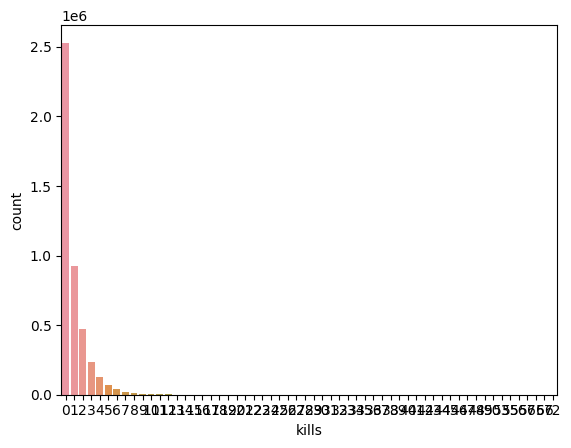

In [17]:
sns.countplot(data, x='kills')

<AxesSubplot: xlabel='kills', ylabel='count'>

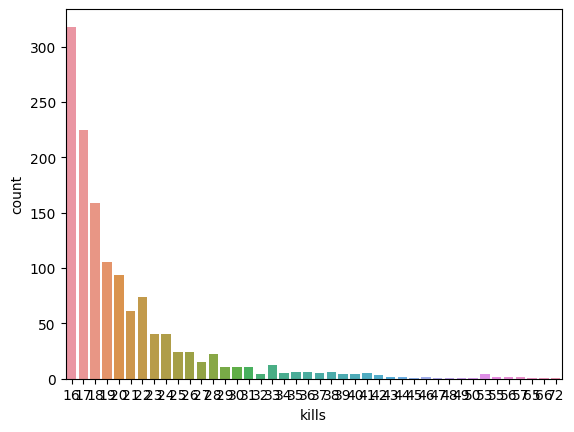

In [18]:
sns.countplot(data[data['kills']>15], x='kills')

As we see, for general player, it is also next to impossible to kill more than 20 players in game.
So I delete the player who has more than 20 kills in game.

In [19]:
data.drop(data[data['kills']>20].index, inplace=True)

Next, I create the new attribute which store the headsot rate.
Means in general game, a player has very less kill by headshot compare to bodyshot.
So, by measuring the headshot rate, I delete the pro player which is not suitable for my model.

In [20]:
data['headshot_rate'] = data['headshotKills'] / data['kills']

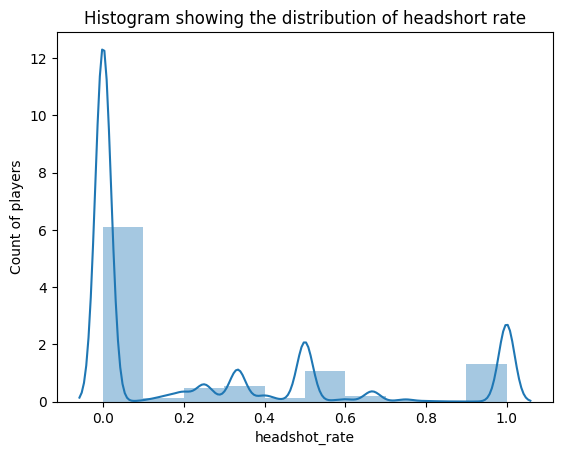

In [21]:
# headshort rate distribution plot
sns.distplot(data['headshot_rate'], bins=10).set_title("Histogram showing the distribution of headshort rate")
plt.ylabel("Count of players")
plt.show()

As we know, headshot is very difficult.
But here, some players have high rate that they kill all players by headshot in game.
So there are also player who kill only 1 or 2 by headshot.
So i delete the player who has headshot rate equal to 1 and kill more than 5 people.

In [22]:
data[(data['headshot_rate'] == 1)&(data['kills'] > 5)].shape

(187, 33)

In [23]:
data.drop(data[(data['headshot_rate'] == 1)&(data['kills'] > 5)].index, inplace=True)

### Longest shot

<img src="https://media.giphy.com/media/RRmwstEMkcvxC/giphy.gif"></img>

Longest shot is also difficult.
I remove the player who kill the enemy more than 500 m range.

In [24]:
data[data['longestKill'] > 500].shape

(1736, 33)

In [25]:
data.drop(data[data['longestKill'] > 500].index, inplace=True)

### Weapon change

<img src="https://media.giphy.com/media/WtpItJkkylJXVOJaba/giphy.gif"></img>

Also, a general player change maximum upto 15 weapons in game.
More than that, he/she should be a pro player or some kind of cheater.

In [26]:
data.drop(data[data['weaponsAcquired']>15].index, inplace=True)

## <font color="green">EDA</font> <a class='anchor' id='eda'></a>

In [27]:
# We remove some players, first we check our new dataset shape
data.shape

(4437609, 33)

<AxesSubplot: >

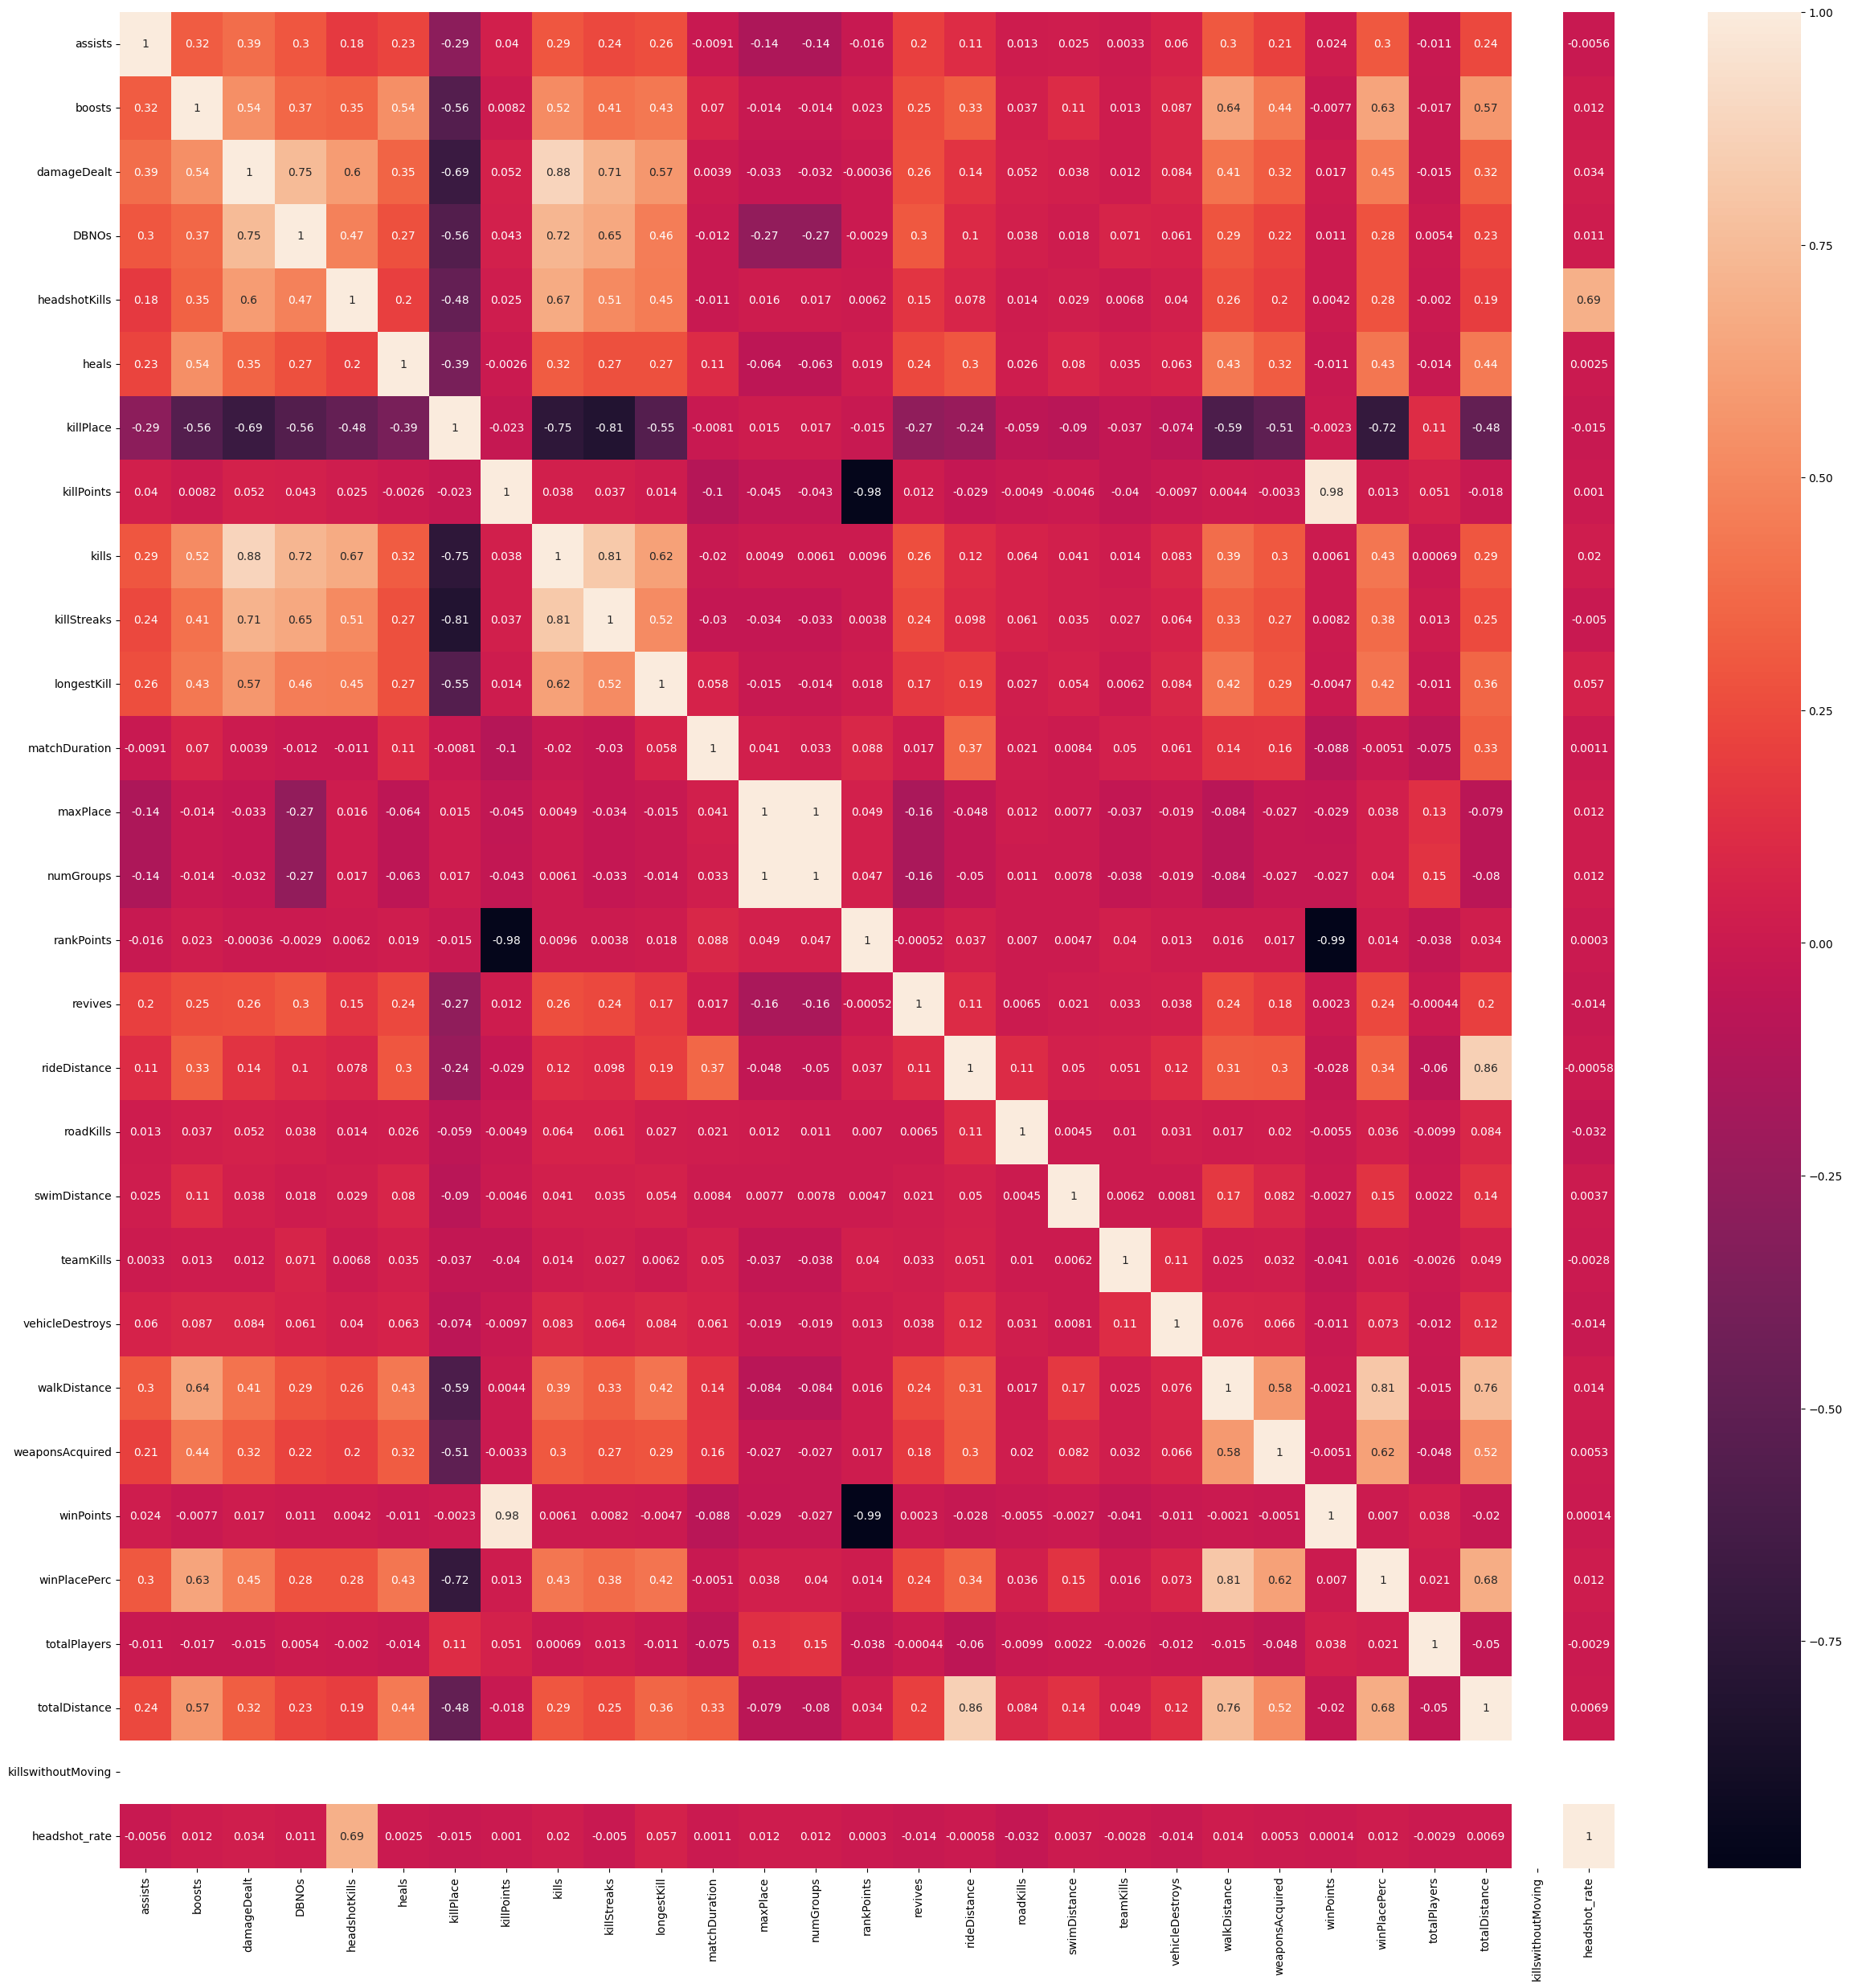

In [28]:
# correlation of parameters with Win Prediction

plt.figure(figsize=(30, 30))
sns.heatmap(data.corr(), annot=True)

## <font color="green">Feature Engineering</font> <a class='anchor' id='feature_engineering'></a>

In [29]:
normalising_factor = (100 - data['totalPlayers']/100) + 1

In [30]:
data['killsNorm'] = data['kills'] * normalising_factor
data['damageDealtNorm'] = data['damageDealt'] * normalising_factor
data['maxPlaceNorm'] = data['maxPlace'] * normalising_factor
data['matchDurationNorm'] = data['matchDuration'] * normalising_factor

data['travelDistance'] = data['totalDistance']
data['healsnboosts'] = data['heals'] + data['boosts']
data['assist'] = data['assists'] + data['revives']


In [31]:
data.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'totalPlayers',
       'totalDistance', 'killswithoutMoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'travelDistance', 'healsnboosts', 'assist'],
      dtype='object')

In [32]:
# Remove unwanted features
new_data = data.drop(columns=['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt',
                             'walkDistance', 'rideDistance', 'swimDistance', 'heals', 'revives', 'kills',
                             'damageDealt', 'maxPlace', 'matchDuration'])

In [53]:
new_data.columns

Index(['DBNOs', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks',
       'longestKill', 'matchType', 'numGroups', 'rankPoints', 'roadKills',
       'teamKills', 'vehicleDestroys', 'weaponsAcquired', 'winPoints',
       'winPlacePerc', 'totalPlayers', 'totalDistance', 'killswithoutMoving',
       'headshot_rate', 'killsNorm', 'damageDealtNorm', 'maxPlaceNorm',
       'matchDurationNorm', 'travelDistance', 'healsnboosts', 'assist'],
      dtype='object')

## <font color="green">ML- Catboosts model</font> <a class='anchor' id='model'></a>

CatBoost model also handle categorical data. So we don't required to handle categorical data.
But to normalize our data, we need to handle the categorical data.

Handling categorical data

In [33]:
x = new_data.drop(['winPlacePerc'], axis=1)
y = new_data['winPlacePerc']

In [34]:
features = x.columns

In [35]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutMoving'])

In [36]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


Scale the data

In [37]:
scaler = StandardScaler()
scaler.fit(x)
x_scaled = scaler.transform(x)

In [38]:
x.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,numGroups,rankPoints,roadKills,teamKills,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutMoving_False
0,0,0,60,1241,0,0.00,26,-1,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,57,0,0,0.00,25,1484,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,0,47,0,0,0.00,47,1491,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,75,0,0,0.00,30,1408,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,45,0,1,58.53,95,1560,0,0,...,0,0,0,0,0,0,1,0,0,1


Splitting data

Split the data into two parts, as training data and testing data.

Using sklearn method <b>train_test_split()<b>

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, random_state=23)

### CatBoost Model

In [40]:
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [41]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [42]:
# Grid Search

grid = {'iterations': [100, 150], 
       'learning_rate':[0.03, 0.1],
       'depth':[2,4,6,8]}
model.grid_search(grid, train_dataset)

0:	learn: 0.5482817	test: 0.5486248	best: 0.5486248 (0)	total: 710ms	remaining: 1m 10s
1:	learn: 0.5334380	test: 0.5337746	best: 0.5337746 (1)	total: 1.14s	remaining: 55.8s
2:	learn: 0.5190820	test: 0.5194095	best: 0.5194095 (2)	total: 1.61s	remaining: 52s
3:	learn: 0.5051804	test: 0.5055050	best: 0.5055050 (3)	total: 1.95s	remaining: 46.9s
4:	learn: 0.4917420	test: 0.4920609	best: 0.4920609 (4)	total: 2.32s	remaining: 44.1s
5:	learn: 0.4787008	test: 0.4790130	best: 0.4790130 (5)	total: 2.62s	remaining: 41s
6:	learn: 0.4661171	test: 0.4664229	best: 0.4664229 (6)	total: 2.87s	remaining: 38.1s
7:	learn: 0.4538959	test: 0.4541979	best: 0.4541979 (7)	total: 3.17s	remaining: 36.4s
8:	learn: 0.4421115	test: 0.4424073	best: 0.4424073 (8)	total: 3.44s	remaining: 34.8s
9:	learn: 0.4306836	test: 0.4309750	best: 0.4309750 (9)	total: 3.75s	remaining: 33.7s
10:	learn: 0.4196281	test: 0.4199157	best: 0.4199157 (10)	total: 4.02s	remaining: 32.6s
11:	learn: 0.4089641	test: 0.4092472	best: 0.4092472 (1

94:	learn: 0.1398900	test: 0.1400266	best: 0.1400266 (94)	total: 20.8s	remaining: 1.1s
95:	learn: 0.1395084	test: 0.1396434	best: 0.1396434 (95)	total: 21s	remaining: 875ms
96:	learn: 0.1391386	test: 0.1392741	best: 0.1392741 (96)	total: 21.2s	remaining: 656ms
97:	learn: 0.1387762	test: 0.1389116	best: 0.1389116 (97)	total: 21.4s	remaining: 436ms
98:	learn: 0.1384365	test: 0.1385705	best: 0.1385705 (98)	total: 21.6s	remaining: 218ms
99:	learn: 0.1381023	test: 0.1382341	best: 0.1382341 (99)	total: 21.8s	remaining: 0us

bestTest = 0.1382341346
bestIteration = 99

0:	loss: 0.1382341	best: 0.1382341 (0)	total: 25.1s	remaining: 6m 16s
0:	learn: 0.5126547	test: 0.5129814	best: 0.5129814 (0)	total: 210ms	remaining: 20.8s
1:	learn: 0.4672011	test: 0.4675071	best: 0.4675071 (1)	total: 456ms	remaining: 22.3s
2:	learn: 0.4267404	test: 0.4270333	best: 0.4270333 (2)	total: 656ms	remaining: 21.2s
3:	learn: 0.3903905	test: 0.3906695	best: 0.3906695 (3)	total: 858ms	remaining: 20.6s
4:	learn: 0.358360

88:	learn: 0.1170427	test: 0.1171360	best: 0.1171360 (88)	total: 18.1s	remaining: 2.24s
89:	learn: 0.1169497	test: 0.1170437	best: 0.1170437 (89)	total: 18.3s	remaining: 2.04s
90:	learn: 0.1168600	test: 0.1169540	best: 0.1169540 (90)	total: 18.5s	remaining: 1.83s
91:	learn: 0.1166651	test: 0.1167589	best: 0.1167589 (91)	total: 18.7s	remaining: 1.63s
92:	learn: 0.1165589	test: 0.1166521	best: 0.1166521 (92)	total: 18.9s	remaining: 1.42s
93:	learn: 0.1164717	test: 0.1165640	best: 0.1165640 (93)	total: 19.1s	remaining: 1.22s
94:	learn: 0.1163753	test: 0.1164669	best: 0.1164669 (94)	total: 19.3s	remaining: 1.01s
95:	learn: 0.1162915	test: 0.1163824	best: 0.1163824 (95)	total: 19.5s	remaining: 811ms
96:	learn: 0.1161975	test: 0.1162874	best: 0.1162874 (96)	total: 19.6s	remaining: 607ms
97:	learn: 0.1161047	test: 0.1161935	best: 0.1161935 (97)	total: 19.8s	remaining: 404ms
98:	learn: 0.1159680	test: 0.1160588	best: 0.1160588 (98)	total: 20s	remaining: 202ms
99:	learn: 0.1158693	test: 0.11595

82:	learn: 0.1460344	test: 0.1461855	best: 0.1461855 (82)	total: 16.2s	remaining: 13s
83:	learn: 0.1454326	test: 0.1455818	best: 0.1455818 (83)	total: 16.4s	remaining: 12.9s
84:	learn: 0.1448585	test: 0.1450067	best: 0.1450067 (84)	total: 16.5s	remaining: 12.6s
85:	learn: 0.1442465	test: 0.1443938	best: 0.1443938 (85)	total: 16.7s	remaining: 12.5s
86:	learn: 0.1436972	test: 0.1438405	best: 0.1438405 (86)	total: 16.9s	remaining: 12.3s
87:	learn: 0.1431754	test: 0.1433185	best: 0.1433185 (87)	total: 17.2s	remaining: 12.1s
88:	learn: 0.1426299	test: 0.1427730	best: 0.1427730 (88)	total: 17.3s	remaining: 11.9s
89:	learn: 0.1421420	test: 0.1422838	best: 0.1422838 (89)	total: 17.5s	remaining: 11.7s
90:	learn: 0.1416773	test: 0.1418169	best: 0.1418169 (90)	total: 17.7s	remaining: 11.5s
91:	learn: 0.1411881	test: 0.1413274	best: 0.1413274 (91)	total: 17.9s	remaining: 11.3s
92:	learn: 0.1407610	test: 0.1408977	best: 0.1408977 (92)	total: 18.1s	remaining: 11.1s
93:	learn: 0.1403386	test: 0.14047

24:	learn: 0.1444772	test: 0.1446207	best: 0.1446207 (24)	total: 4.72s	remaining: 23.6s
25:	learn: 0.1425479	test: 0.1426870	best: 0.1426870 (25)	total: 4.92s	remaining: 23.5s
26:	learn: 0.1409978	test: 0.1411375	best: 0.1411375 (26)	total: 5.08s	remaining: 23.2s
27:	learn: 0.1395991	test: 0.1397349	best: 0.1397349 (27)	total: 5.26s	remaining: 22.9s
28:	learn: 0.1382396	test: 0.1383782	best: 0.1383782 (28)	total: 5.45s	remaining: 22.7s
29:	learn: 0.1371411	test: 0.1372740	best: 0.1372740 (29)	total: 5.67s	remaining: 22.7s
30:	learn: 0.1361810	test: 0.1363104	best: 0.1363104 (30)	total: 5.85s	remaining: 22.4s
31:	learn: 0.1353262	test: 0.1354509	best: 0.1354509 (31)	total: 6.03s	remaining: 22.2s
32:	learn: 0.1345187	test: 0.1346427	best: 0.1346427 (32)	total: 6.2s	remaining: 22s
33:	learn: 0.1338019	test: 0.1339203	best: 0.1339203 (33)	total: 6.37s	remaining: 21.7s
34:	learn: 0.1329556	test: 0.1330735	best: 0.1330735 (34)	total: 6.54s	remaining: 21.5s
35:	learn: 0.1323137	test: 0.132428

118:	learn: 0.1131117	test: 0.1131986	best: 0.1131986 (118)	total: 22.1s	remaining: 5.75s
119:	learn: 0.1130362	test: 0.1131227	best: 0.1131227 (119)	total: 22.2s	remaining: 5.56s
120:	learn: 0.1129700	test: 0.1130538	best: 0.1130538 (120)	total: 22.4s	remaining: 5.37s
121:	learn: 0.1128984	test: 0.1129829	best: 0.1129829 (121)	total: 22.6s	remaining: 5.19s
122:	learn: 0.1127968	test: 0.1128823	best: 0.1128823 (122)	total: 22.9s	remaining: 5.02s
123:	learn: 0.1126044	test: 0.1126907	best: 0.1126907 (123)	total: 23.1s	remaining: 4.84s
124:	learn: 0.1125191	test: 0.1126036	best: 0.1126036 (124)	total: 23.3s	remaining: 4.66s
125:	learn: 0.1124555	test: 0.1125422	best: 0.1125422 (125)	total: 23.5s	remaining: 4.47s
126:	learn: 0.1123527	test: 0.1124388	best: 0.1124388 (126)	total: 23.7s	remaining: 4.29s
127:	learn: 0.1123016	test: 0.1123873	best: 0.1123873 (127)	total: 23.9s	remaining: 4.11s
128:	learn: 0.1122370	test: 0.1123194	best: 0.1123194 (128)	total: 24.1s	remaining: 3.92s
129:	learn

60:	learn: 0.1532818	test: 0.1534268	best: 0.1534268 (60)	total: 16.2s	remaining: 10.4s
61:	learn: 0.1516082	test: 0.1517503	best: 0.1517503 (61)	total: 16.5s	remaining: 10.1s
62:	learn: 0.1499579	test: 0.1500990	best: 0.1500990 (62)	total: 16.8s	remaining: 9.84s
63:	learn: 0.1484238	test: 0.1485643	best: 0.1485643 (63)	total: 17s	remaining: 9.57s
64:	learn: 0.1469898	test: 0.1471280	best: 0.1471280 (64)	total: 17.3s	remaining: 9.29s
65:	learn: 0.1455968	test: 0.1457320	best: 0.1457320 (65)	total: 17.5s	remaining: 9.02s
66:	learn: 0.1442412	test: 0.1443752	best: 0.1443752 (66)	total: 17.8s	remaining: 8.75s
67:	learn: 0.1429247	test: 0.1430582	best: 0.1430582 (67)	total: 18s	remaining: 8.47s
68:	learn: 0.1416773	test: 0.1418076	best: 0.1418076 (68)	total: 18.3s	remaining: 8.2s
69:	learn: 0.1404876	test: 0.1406175	best: 0.1406175 (69)	total: 18.5s	remaining: 7.93s
70:	learn: 0.1393504	test: 0.1394792	best: 0.1394792 (70)	total: 18.8s	remaining: 7.67s
71:	learn: 0.1382538	test: 0.1383814	

53:	learn: 0.1052124	test: 0.1052685	best: 0.1052685 (53)	total: 13.7s	remaining: 11.6s
54:	learn: 0.1050282	test: 0.1050829	best: 0.1050829 (54)	total: 13.9s	remaining: 11.3s
55:	learn: 0.1045312	test: 0.1045888	best: 0.1045888 (55)	total: 14.1s	remaining: 11.1s
56:	learn: 0.1043830	test: 0.1044431	best: 0.1044431 (56)	total: 14.3s	remaining: 10.8s
57:	learn: 0.1042048	test: 0.1042630	best: 0.1042630 (57)	total: 14.6s	remaining: 10.5s
58:	learn: 0.1040048	test: 0.1040664	best: 0.1040664 (58)	total: 14.8s	remaining: 10.3s
59:	learn: 0.1036634	test: 0.1037266	best: 0.1037266 (59)	total: 15.1s	remaining: 10s
60:	learn: 0.1034569	test: 0.1035220	best: 0.1035220 (60)	total: 15.3s	remaining: 9.77s
61:	learn: 0.1032732	test: 0.1033347	best: 0.1033347 (61)	total: 15.5s	remaining: 9.48s
62:	learn: 0.1031319	test: 0.1031961	best: 0.1031961 (62)	total: 15.7s	remaining: 9.22s
63:	learn: 0.1028652	test: 0.1029263	best: 0.1029263 (63)	total: 15.9s	remaining: 8.97s
64:	learn: 0.1027029	test: 0.10275

46:	learn: 0.1865943	test: 0.1867694	best: 0.1867694 (46)	total: 12.4s	remaining: 27.1s
47:	learn: 0.1836090	test: 0.1837816	best: 0.1837816 (47)	total: 12.6s	remaining: 26.8s
48:	learn: 0.1807249	test: 0.1808949	best: 0.1808949 (48)	total: 12.9s	remaining: 26.6s
49:	learn: 0.1778242	test: 0.1779932	best: 0.1779932 (49)	total: 13.2s	remaining: 26.3s
50:	learn: 0.1751780	test: 0.1753427	best: 0.1753427 (50)	total: 13.4s	remaining: 26.1s
51:	learn: 0.1724760	test: 0.1726383	best: 0.1726383 (51)	total: 13.7s	remaining: 25.8s
52:	learn: 0.1700347	test: 0.1701942	best: 0.1701942 (52)	total: 14s	remaining: 25.5s
53:	learn: 0.1677006	test: 0.1678590	best: 0.1678590 (53)	total: 14.2s	remaining: 25.3s
54:	learn: 0.1653140	test: 0.1654712	best: 0.1654712 (54)	total: 14.5s	remaining: 25s
55:	learn: 0.1630371	test: 0.1631922	best: 0.1631922 (55)	total: 14.7s	remaining: 24.8s
56:	learn: 0.1608496	test: 0.1610028	best: 0.1610028 (56)	total: 15s	remaining: 24.5s
57:	learn: 0.1587744	test: 0.1589266	b

139:	learn: 0.1104923	test: 0.1105498	best: 0.1105498 (139)	total: 41.1s	remaining: 2.94s
140:	learn: 0.1103431	test: 0.1104004	best: 0.1104004 (140)	total: 41.4s	remaining: 2.64s
141:	learn: 0.1102096	test: 0.1102668	best: 0.1102668 (141)	total: 41.7s	remaining: 2.35s
142:	learn: 0.1100950	test: 0.1101517	best: 0.1101517 (142)	total: 41.9s	remaining: 2.05s
143:	learn: 0.1099147	test: 0.1099714	best: 0.1099714 (143)	total: 42.2s	remaining: 1.76s
144:	learn: 0.1098099	test: 0.1098667	best: 0.1098667 (144)	total: 42.5s	remaining: 1.46s
145:	learn: 0.1096950	test: 0.1097526	best: 0.1097526 (145)	total: 42.7s	remaining: 1.17s
146:	learn: 0.1095960	test: 0.1096539	best: 0.1096539 (146)	total: 43s	remaining: 878ms
147:	learn: 0.1094649	test: 0.1095221	best: 0.1095221 (147)	total: 43.3s	remaining: 585ms
148:	learn: 0.1093740	test: 0.1094312	best: 0.1094312 (148)	total: 43.5s	remaining: 292ms
149:	learn: 0.1091446	test: 0.1091998	best: 0.1091998 (149)	total: 43.8s	remaining: 0us

bestTest = 0.

82:	learn: 0.0987056	test: 0.0987536	best: 0.0987536 (82)	total: 22.1s	remaining: 17.8s
83:	learn: 0.0986042	test: 0.0986529	best: 0.0986529 (83)	total: 22.3s	remaining: 17.5s
84:	learn: 0.0984143	test: 0.0984659	best: 0.0984659 (84)	total: 22.6s	remaining: 17.3s
85:	learn: 0.0982491	test: 0.0982986	best: 0.0982986 (85)	total: 22.8s	remaining: 17s
86:	learn: 0.0981770	test: 0.0982262	best: 0.0982262 (86)	total: 23s	remaining: 16.7s
87:	learn: 0.0979878	test: 0.0980324	best: 0.0980324 (87)	total: 23.3s	remaining: 16.4s
88:	learn: 0.0979196	test: 0.0979651	best: 0.0979651 (88)	total: 23.6s	remaining: 16.1s
89:	learn: 0.0978185	test: 0.0978654	best: 0.0978654 (89)	total: 23.8s	remaining: 15.9s
90:	learn: 0.0976596	test: 0.0977042	best: 0.0977042 (90)	total: 24.1s	remaining: 15.6s
91:	learn: 0.0974388	test: 0.0974858	best: 0.0974858 (91)	total: 24.3s	remaining: 15.3s
92:	learn: 0.0971545	test: 0.0972044	best: 0.0972044 (92)	total: 24.6s	remaining: 15.1s
93:	learn: 0.0969953	test: 0.0970446

24:	learn: 0.2868746	test: 0.2870785	best: 0.2870785 (24)	total: 9.15s	remaining: 27.4s
25:	learn: 0.2798470	test: 0.2800498	best: 0.2800498 (25)	total: 9.51s	remaining: 27.1s
26:	learn: 0.2731004	test: 0.2733007	best: 0.2733007 (26)	total: 9.9s	remaining: 26.8s
27:	learn: 0.2665890	test: 0.2667850	best: 0.2667850 (27)	total: 10.3s	remaining: 26.4s
28:	learn: 0.2603207	test: 0.2605124	best: 0.2605124 (28)	total: 10.6s	remaining: 26s
29:	learn: 0.2542474	test: 0.2544373	best: 0.2544373 (29)	total: 11s	remaining: 25.6s
30:	learn: 0.2483932	test: 0.2485790	best: 0.2485790 (30)	total: 11.3s	remaining: 25.2s
31:	learn: 0.2427585	test: 0.2429450	best: 0.2429450 (31)	total: 11.7s	remaining: 24.8s
32:	learn: 0.2372254	test: 0.2374072	best: 0.2374072 (32)	total: 12s	remaining: 24.4s
33:	learn: 0.2319338	test: 0.2321127	best: 0.2321127 (33)	total: 12.4s	remaining: 24.1s
34:	learn: 0.2268522	test: 0.2270274	best: 0.2270274 (34)	total: 12.8s	remaining: 23.7s
35:	learn: 0.2219483	test: 0.2221217	be

17:	learn: 0.1422808	test: 0.1424143	best: 0.1424143 (17)	total: 6.61s	remaining: 30.1s
18:	learn: 0.1368415	test: 0.1369684	best: 0.1369684 (18)	total: 6.96s	remaining: 29.7s
19:	learn: 0.1321682	test: 0.1322913	best: 0.1322913 (19)	total: 7.28s	remaining: 29.1s
20:	learn: 0.1282220	test: 0.1283423	best: 0.1283423 (20)	total: 7.62s	remaining: 28.6s
21:	learn: 0.1244583	test: 0.1245665	best: 0.1245665 (21)	total: 7.93s	remaining: 28.1s
22:	learn: 0.1215594	test: 0.1216683	best: 0.1216683 (22)	total: 8.26s	remaining: 27.7s
23:	learn: 0.1187754	test: 0.1188763	best: 0.1188763 (23)	total: 8.61s	remaining: 27.3s
24:	learn: 0.1164879	test: 0.1165871	best: 0.1165871 (24)	total: 8.91s	remaining: 26.7s
25:	learn: 0.1143462	test: 0.1144306	best: 0.1144306 (25)	total: 9.2s	remaining: 26.2s
26:	learn: 0.1123235	test: 0.1123992	best: 0.1123992 (26)	total: 9.52s	remaining: 25.7s
27:	learn: 0.1106194	test: 0.1106869	best: 0.1106869 (27)	total: 9.84s	remaining: 25.3s
28:	learn: 0.1091283	test: 0.1091

10:	learn: 0.4141266	test: 0.4143956	best: 0.4143956 (10)	total: 3.88s	remaining: 49.1s
11:	learn: 0.4030180	test: 0.4032801	best: 0.4032801 (11)	total: 4.22s	remaining: 48.5s
12:	learn: 0.3922505	test: 0.3925076	best: 0.3925076 (12)	total: 4.52s	remaining: 47.6s
13:	learn: 0.3817823	test: 0.3820354	best: 0.3820354 (13)	total: 4.86s	remaining: 47.2s
14:	learn: 0.3716428	test: 0.3718930	best: 0.3718930 (14)	total: 5.19s	remaining: 46.7s
15:	learn: 0.3618400	test: 0.3620809	best: 0.3620809 (15)	total: 5.54s	remaining: 46.4s
16:	learn: 0.3523565	test: 0.3525918	best: 0.3525918 (16)	total: 5.86s	remaining: 45.8s
17:	learn: 0.3431445	test: 0.3433764	best: 0.3433764 (17)	total: 6.18s	remaining: 45.3s
18:	learn: 0.3342763	test: 0.3345026	best: 0.3345026 (18)	total: 6.51s	remaining: 44.9s
19:	learn: 0.3257381	test: 0.3259569	best: 0.3259569 (19)	total: 6.86s	remaining: 44.6s
20:	learn: 0.3174167	test: 0.3176334	best: 0.3176334 (20)	total: 7.18s	remaining: 44.1s
21:	learn: 0.3093410	test: 0.309

104:	learn: 0.1075211	test: 0.1076058	best: 0.1076058 (104)	total: 34.3s	remaining: 14.7s
105:	learn: 0.1072475	test: 0.1073320	best: 0.1073320 (105)	total: 34.7s	remaining: 14.4s
106:	learn: 0.1069658	test: 0.1070508	best: 0.1070508 (106)	total: 35s	remaining: 14.1s
107:	learn: 0.1066698	test: 0.1067546	best: 0.1067546 (107)	total: 35.3s	remaining: 13.7s
108:	learn: 0.1064298	test: 0.1065157	best: 0.1065157 (108)	total: 35.6s	remaining: 13.4s
109:	learn: 0.1060979	test: 0.1061810	best: 0.1061810 (109)	total: 35.9s	remaining: 13.1s
110:	learn: 0.1058740	test: 0.1059574	best: 0.1059574 (110)	total: 36.3s	remaining: 12.7s
111:	learn: 0.1056513	test: 0.1057345	best: 0.1057345 (111)	total: 36.6s	remaining: 12.4s
112:	learn: 0.1054274	test: 0.1055100	best: 0.1055100 (112)	total: 36.9s	remaining: 12.1s
113:	learn: 0.1051250	test: 0.1052048	best: 0.1052048 (113)	total: 37.2s	remaining: 11.8s
114:	learn: 0.1048982	test: 0.1049792	best: 0.1049792 (114)	total: 37.5s	remaining: 11.4s
115:	learn: 

46:	learn: 0.0977000	test: 0.0977405	best: 0.0977405 (46)	total: 15.2s	remaining: 33.3s
47:	learn: 0.0973838	test: 0.0974230	best: 0.0974230 (47)	total: 15.5s	remaining: 33s
48:	learn: 0.0970756	test: 0.0971120	best: 0.0971120 (48)	total: 15.8s	remaining: 32.5s
49:	learn: 0.0965283	test: 0.0965640	best: 0.0965640 (49)	total: 16.2s	remaining: 32.3s
50:	learn: 0.0962240	test: 0.0962648	best: 0.0962648 (50)	total: 16.4s	remaining: 31.9s
51:	learn: 0.0959305	test: 0.0959660	best: 0.0959660 (51)	total: 16.8s	remaining: 31.6s
52:	learn: 0.0957374	test: 0.0957729	best: 0.0957729 (52)	total: 17.1s	remaining: 31.2s
53:	learn: 0.0954886	test: 0.0955291	best: 0.0955291 (53)	total: 17.3s	remaining: 30.8s
54:	learn: 0.0952895	test: 0.0953305	best: 0.0953305 (54)	total: 17.7s	remaining: 30.5s
55:	learn: 0.0951306	test: 0.0951727	best: 0.0951727 (55)	total: 18s	remaining: 30.2s
56:	learn: 0.0945838	test: 0.0946188	best: 0.0946188 (56)	total: 18.3s	remaining: 29.8s
57:	learn: 0.0944050	test: 0.0944379

139:	learn: 0.0850219	test: 0.0850754	best: 0.0850754 (139)	total: 42.7s	remaining: 3.05s
140:	learn: 0.0849745	test: 0.0850285	best: 0.0850285 (140)	total: 43.1s	remaining: 2.75s
141:	learn: 0.0849126	test: 0.0849683	best: 0.0849683 (141)	total: 43.3s	remaining: 2.44s
142:	learn: 0.0848290	test: 0.0848848	best: 0.0848848 (142)	total: 43.7s	remaining: 2.14s
143:	learn: 0.0848001	test: 0.0848560	best: 0.0848560 (143)	total: 43.9s	remaining: 1.83s
144:	learn: 0.0847535	test: 0.0848087	best: 0.0848087 (144)	total: 44.2s	remaining: 1.52s
145:	learn: 0.0847008	test: 0.0847592	best: 0.0847592 (145)	total: 44.5s	remaining: 1.22s
146:	learn: 0.0846550	test: 0.0847129	best: 0.0847129 (146)	total: 44.8s	remaining: 914ms
147:	learn: 0.0846143	test: 0.0846741	best: 0.0846741 (147)	total: 45s	remaining: 608ms
148:	learn: 0.0845879	test: 0.0846503	best: 0.0846503 (148)	total: 45.3s	remaining: 304ms
149:	learn: 0.0845099	test: 0.0845699	best: 0.0845699 (149)	total: 45.6s	remaining: 0us

bestTest = 0.

82:	learn: 0.1106625	test: 0.1107122	best: 0.1107122 (82)	total: 34s	remaining: 6.95s
83:	learn: 0.1099734	test: 0.1100224	best: 0.1100224 (83)	total: 34.3s	remaining: 6.54s
84:	learn: 0.1093120	test: 0.1093646	best: 0.1093646 (84)	total: 34.7s	remaining: 6.12s
85:	learn: 0.1086794	test: 0.1087338	best: 0.1087338 (85)	total: 35.1s	remaining: 5.72s
86:	learn: 0.1080330	test: 0.1080876	best: 0.1080876 (86)	total: 35.5s	remaining: 5.3s
87:	learn: 0.1074512	test: 0.1075060	best: 0.1075060 (87)	total: 35.9s	remaining: 4.89s
88:	learn: 0.1068785	test: 0.1069324	best: 0.1069324 (88)	total: 36.3s	remaining: 4.49s
89:	learn: 0.1063464	test: 0.1064002	best: 0.1064002 (89)	total: 36.7s	remaining: 4.08s
90:	learn: 0.1058039	test: 0.1058570	best: 0.1058570 (90)	total: 37.2s	remaining: 3.67s
91:	learn: 0.1053187	test: 0.1053719	best: 0.1053719 (91)	total: 37.5s	remaining: 3.26s
92:	learn: 0.1047971	test: 0.1048494	best: 0.1048494 (92)	total: 37.9s	remaining: 2.86s
93:	learn: 0.1043148	test: 0.104365

75:	learn: 0.0865624	test: 0.0866149	best: 0.0866149 (75)	total: 28.8s	remaining: 9.09s
76:	learn: 0.0864798	test: 0.0865321	best: 0.0865321 (76)	total: 29.2s	remaining: 8.71s
77:	learn: 0.0862747	test: 0.0863244	best: 0.0863244 (77)	total: 29.5s	remaining: 8.32s
78:	learn: 0.0860871	test: 0.0861340	best: 0.0861340 (78)	total: 29.9s	remaining: 7.94s
79:	learn: 0.0859875	test: 0.0860354	best: 0.0860354 (79)	total: 30.3s	remaining: 7.57s
80:	learn: 0.0859227	test: 0.0859744	best: 0.0859744 (80)	total: 30.6s	remaining: 7.18s
81:	learn: 0.0858245	test: 0.0858750	best: 0.0858750 (81)	total: 31s	remaining: 6.81s
82:	learn: 0.0857626	test: 0.0858141	best: 0.0858141 (82)	total: 31.4s	remaining: 6.44s
83:	learn: 0.0856551	test: 0.0857081	best: 0.0857081 (83)	total: 31.7s	remaining: 6.04s
84:	learn: 0.0855374	test: 0.0855891	best: 0.0855891 (84)	total: 32.1s	remaining: 5.66s
85:	learn: 0.0854752	test: 0.0855287	best: 0.0855287 (85)	total: 32.4s	remaining: 5.28s
86:	learn: 0.0853225	test: 0.08537

68:	learn: 0.1248792	test: 0.1249415	best: 0.1249415 (68)	total: 28.4s	remaining: 33.3s
69:	learn: 0.1235319	test: 0.1235915	best: 0.1235915 (69)	total: 28.8s	remaining: 32.9s
70:	learn: 0.1223001	test: 0.1223597	best: 0.1223597 (70)	total: 29.1s	remaining: 32.4s
71:	learn: 0.1210345	test: 0.1210932	best: 0.1210932 (71)	total: 29.6s	remaining: 32.1s
72:	learn: 0.1198360	test: 0.1198920	best: 0.1198920 (72)	total: 30s	remaining: 31.6s
73:	learn: 0.1187426	test: 0.1188005	best: 0.1188005 (73)	total: 30.5s	remaining: 31.3s
74:	learn: 0.1177165	test: 0.1177749	best: 0.1177749 (74)	total: 30.8s	remaining: 30.8s
75:	learn: 0.1166540	test: 0.1167086	best: 0.1167086 (75)	total: 31.3s	remaining: 30.4s
76:	learn: 0.1156817	test: 0.1157348	best: 0.1157348 (76)	total: 31.7s	remaining: 30.1s
77:	learn: 0.1147391	test: 0.1147899	best: 0.1147899 (77)	total: 32.1s	remaining: 29.7s
78:	learn: 0.1138673	test: 0.1139177	best: 0.1139177 (78)	total: 32.6s	remaining: 29.3s
79:	learn: 0.1129822	test: 0.11303

10:	learn: 0.2084791	test: 0.2086245	best: 0.2086245 (10)	total: 4.56s	remaining: 57.7s
11:	learn: 0.1935731	test: 0.1937043	best: 0.1937043 (11)	total: 4.98s	remaining: 57.2s
12:	learn: 0.1804545	test: 0.1805753	best: 0.1805753 (12)	total: 5.37s	remaining: 56.6s
13:	learn: 0.1690094	test: 0.1691203	best: 0.1691203 (13)	total: 5.77s	remaining: 56.1s
14:	learn: 0.1589004	test: 0.1590093	best: 0.1590093 (14)	total: 6.17s	remaining: 55.5s
15:	learn: 0.1502515	test: 0.1503541	best: 0.1503541 (15)	total: 6.55s	remaining: 54.8s
16:	learn: 0.1425903	test: 0.1426941	best: 0.1426941 (16)	total: 6.95s	remaining: 54.4s
17:	learn: 0.1360729	test: 0.1361769	best: 0.1361769 (17)	total: 7.33s	remaining: 53.7s
18:	learn: 0.1302066	test: 0.1302984	best: 0.1302984 (18)	total: 7.77s	remaining: 53.6s
19:	learn: 0.1254154	test: 0.1255088	best: 0.1255088 (19)	total: 8.16s	remaining: 53s
20:	learn: 0.1213134	test: 0.1214025	best: 0.1214025 (20)	total: 8.54s	remaining: 52.4s
21:	learn: 0.1176757	test: 0.11776

104:	learn: 0.0840027	test: 0.0840800	best: 0.0840800 (104)	total: 39.2s	remaining: 16.8s
105:	learn: 0.0839397	test: 0.0840188	best: 0.0840188 (105)	total: 39.5s	remaining: 16.4s
106:	learn: 0.0839062	test: 0.0839871	best: 0.0839871 (106)	total: 39.9s	remaining: 16s
107:	learn: 0.0838541	test: 0.0839374	best: 0.0839374 (107)	total: 40.3s	remaining: 15.7s
108:	learn: 0.0837923	test: 0.0838765	best: 0.0838765 (108)	total: 40.7s	remaining: 15.3s
109:	learn: 0.0837347	test: 0.0838194	best: 0.0838194 (109)	total: 41s	remaining: 14.9s
110:	learn: 0.0836491	test: 0.0837338	best: 0.0837338 (110)	total: 41.3s	remaining: 14.5s
111:	learn: 0.0836185	test: 0.0837055	best: 0.0837055 (111)	total: 41.6s	remaining: 14.1s
112:	learn: 0.0835532	test: 0.0836391	best: 0.0836391 (112)	total: 42s	remaining: 13.8s
113:	learn: 0.0835161	test: 0.0836039	best: 0.0836039 (113)	total: 42.4s	remaining: 13.4s
114:	learn: 0.0834712	test: 0.0835599	best: 0.0835599 (114)	total: 42.8s	remaining: 13s
115:	learn: 0.0834

45:	learn: 0.0914509	test: 0.0913086	best: 0.0913086 (45)	total: 15.3s	remaining: 34.6s
46:	learn: 0.0910902	test: 0.0909577	best: 0.0909577 (46)	total: 15.6s	remaining: 34.2s
47:	learn: 0.0905876	test: 0.0904640	best: 0.0904640 (47)	total: 16s	remaining: 34.1s
48:	learn: 0.0903520	test: 0.0902326	best: 0.0902326 (48)	total: 16.3s	remaining: 33.6s
49:	learn: 0.0901164	test: 0.0899972	best: 0.0899972 (49)	total: 16.7s	remaining: 33.4s
50:	learn: 0.0899362	test: 0.0898209	best: 0.0898209 (50)	total: 17s	remaining: 32.9s
51:	learn: 0.0896629	test: 0.0895553	best: 0.0895553 (51)	total: 17.3s	remaining: 32.6s
52:	learn: 0.0893792	test: 0.0892784	best: 0.0892784 (52)	total: 17.7s	remaining: 32.3s
53:	learn: 0.0891684	test: 0.0890691	best: 0.0890691 (53)	total: 18s	remaining: 32s
54:	learn: 0.0889589	test: 0.0888611	best: 0.0888611 (54)	total: 18.4s	remaining: 31.7s
55:	learn: 0.0888149	test: 0.0887163	best: 0.0887163 (55)	total: 18.7s	remaining: 31.3s
56:	learn: 0.0886187	test: 0.0885217	bes

138:	learn: 0.0825293	test: 0.0826205	best: 0.0826205 (138)	total: 47.8s	remaining: 3.78s
139:	learn: 0.0825012	test: 0.0825921	best: 0.0825921 (139)	total: 48.1s	remaining: 3.44s
140:	learn: 0.0824669	test: 0.0825586	best: 0.0825586 (140)	total: 48.5s	remaining: 3.09s
141:	learn: 0.0824347	test: 0.0825268	best: 0.0825268 (141)	total: 48.8s	remaining: 2.75s
142:	learn: 0.0823851	test: 0.0824776	best: 0.0824776 (142)	total: 49.1s	remaining: 2.4s
143:	learn: 0.0823551	test: 0.0824478	best: 0.0824478 (143)	total: 49.5s	remaining: 2.06s
144:	learn: 0.0823217	test: 0.0824172	best: 0.0824172 (144)	total: 49.7s	remaining: 1.71s
145:	learn: 0.0822918	test: 0.0823918	best: 0.0823918 (145)	total: 50.1s	remaining: 1.37s
146:	learn: 0.0822507	test: 0.0823533	best: 0.0823533 (146)	total: 50.5s	remaining: 1.03s
147:	learn: 0.0822174	test: 0.0823219	best: 0.0823219 (147)	total: 50.8s	remaining: 687ms
148:	learn: 0.0821930	test: 0.0822979	best: 0.0822979 (148)	total: 51.1s	remaining: 343ms
149:	learn:

81:	learn: 0.0855509	test: 0.0858196	best: 0.0858196 (81)	total: 28s	remaining: 23.2s
82:	learn: 0.0854481	test: 0.0857184	best: 0.0857184 (82)	total: 28.3s	remaining: 22.9s
83:	learn: 0.0853438	test: 0.0856173	best: 0.0856173 (83)	total: 28.6s	remaining: 22.5s
84:	learn: 0.0852862	test: 0.0855595	best: 0.0855595 (84)	total: 28.9s	remaining: 22.1s
85:	learn: 0.0852080	test: 0.0854793	best: 0.0854793 (85)	total: 29.2s	remaining: 21.7s
86:	learn: 0.0850940	test: 0.0853685	best: 0.0853685 (86)	total: 29.5s	remaining: 21.3s
87:	learn: 0.0850026	test: 0.0852781	best: 0.0852781 (87)	total: 29.8s	remaining: 21s
88:	learn: 0.0849042	test: 0.0851789	best: 0.0851789 (88)	total: 30.1s	remaining: 20.6s
89:	learn: 0.0847856	test: 0.0850627	best: 0.0850627 (89)	total: 30.4s	remaining: 20.2s
90:	learn: 0.0847253	test: 0.0850002	best: 0.0850002 (90)	total: 30.6s	remaining: 19.9s
91:	learn: 0.0846479	test: 0.0849242	best: 0.0849242 (91)	total: 30.9s	remaining: 19.5s
92:	learn: 0.0845897	test: 0.0848649

23:	learn: 0.1110228	test: 0.1111346	best: 0.1111346 (23)	total: 8.06s	remaining: 42.3s
24:	learn: 0.1087884	test: 0.1089087	best: 0.1089087 (24)	total: 8.35s	remaining: 41.7s
25:	learn: 0.1064952	test: 0.1066103	best: 0.1066103 (25)	total: 8.69s	remaining: 41.5s
26:	learn: 0.1047558	test: 0.1048737	best: 0.1048737 (26)	total: 9.03s	remaining: 41.1s
27:	learn: 0.1030360	test: 0.1031463	best: 0.1031463 (27)	total: 9.37s	remaining: 40.8s
28:	learn: 0.1017189	test: 0.1018272	best: 0.1018272 (28)	total: 9.7s	remaining: 40.5s
29:	learn: 0.1005863	test: 0.1006861	best: 0.1006861 (29)	total: 10s	remaining: 40.1s
30:	learn: 0.0995994	test: 0.0996947	best: 0.0996947 (30)	total: 10.4s	remaining: 39.8s
31:	learn: 0.0985741	test: 0.0986672	best: 0.0986672 (31)	total: 10.7s	remaining: 39.3s
32:	learn: 0.0978044	test: 0.0978982	best: 0.0978982 (32)	total: 11s	remaining: 38.9s
33:	learn: 0.0970984	test: 0.0971926	best: 0.0971926 (33)	total: 11.3s	remaining: 38.5s
34:	learn: 0.0964903	test: 0.0965890	

117:	learn: 0.0832757	test: 0.0833072	best: 0.0833072 (117)	total: 35.8s	remaining: 9.71s
118:	learn: 0.0832443	test: 0.0832761	best: 0.0832761 (118)	total: 36.1s	remaining: 9.41s
119:	learn: 0.0832166	test: 0.0832506	best: 0.0832506 (119)	total: 36.4s	remaining: 9.09s
120:	learn: 0.0831820	test: 0.0832161	best: 0.0832161 (120)	total: 36.7s	remaining: 8.79s
121:	learn: 0.0831473	test: 0.0831813	best: 0.0831813 (121)	total: 37s	remaining: 8.48s
122:	learn: 0.0831116	test: 0.0831481	best: 0.0831481 (122)	total: 37.2s	remaining: 8.17s
123:	learn: 0.0830591	test: 0.0830930	best: 0.0830930 (123)	total: 37.5s	remaining: 7.87s
124:	learn: 0.0830081	test: 0.0830420	best: 0.0830420 (124)	total: 37.8s	remaining: 7.57s
125:	learn: 0.0829823	test: 0.0830169	best: 0.0830169 (125)	total: 38.1s	remaining: 7.26s
126:	learn: 0.0829531	test: 0.0829899	best: 0.0829899 (126)	total: 38.4s	remaining: 6.95s
127:	learn: 0.0829189	test: 0.0829593	best: 0.0829593 (127)	total: 38.7s	remaining: 6.64s
128:	learn: 

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

## <font color='green'>Prediction</font><a class='anchor' id='prediction'></a>

In [44]:
pred = model.predict(X_test)

In [45]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)

print("Testing performance...\n\n")
print("RMSE\t:", rmse)
print("R2 Score\t:", r2)

Testing performance...


RMSE	: 0.08219537954536858
R2 Score	: 0.9284230123168806


<img src="https://media.giphy.com/media/etKSrsbbKbqwW6vzOg/giphy.gif"></img>

In [47]:
features

Index(['DBNOs', 'headshotKills', 'killPlace', 'killPoints', 'killStreaks',
       'longestKill', 'matchType', 'numGroups', 'rankPoints', 'roadKills',
       'teamKills', 'vehicleDestroys', 'weaponsAcquired', 'winPoints',
       'totalPlayers', 'totalDistance', 'killswithoutMoving', 'headshot_rate',
       'killsNorm', 'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'travelDistance', 'healsnboosts', 'assist'],
      dtype='object')

### After train the model, and evaluation
### I save our model.

In [48]:
model.save_model("pubg_cat_model.bin")